## Calibrate AD99 parameters to check deficiency cannot be corrected
### Load data


In [36]:
import matplotlib.pyplot as plt
plt.rcParams.update ({
'font.family':"sans-serif",
'font.style': 'normal',
'font.size':16.5,
})

In [1]:
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt
from ad99py.masks import mask_dataset
BASIN = None 
FIGDIR = '../../figures'
DATADIR = '../data'
exp = 'AD99 c0=u0 (include unbroken)'
expcode = 'always_include_unbroken_1year'

# ERA5_DATASET = f"{DATADIR}/"
GCM_DATASET = f"{DATADIR}/{expcode}.nc"


# ds_era5 = xr.open_dataset(ERA5_DATASET)
ds_gcm = xr.open_dataset(GCM_DATASET,chunks={'time':1})


# ds_era5 = mask_dataset(ds_era5,dir=DATADIR,basins=BASIN)
ds_gcm = mask_dataset(ds_gcm,dir=DATADIR,basins=BASIN)

# ds_era5 = ds_era5.transpose('time','points','level')
ds_gcm = ds_gcm.transpose('time','points','level')

/Users/robcking/miniconda3/envs/loon_gw/lib/python3.13/site-packages/dask/_task_spec.py:741: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/Users/robcking/miniconda3/envs/loon_gw/lib/python3.13/site-packages/dask/_task_spec.py:741: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/Users/robcking/miniconda3/envs/loon_gw/lib/python3.13/site-packages/dask/_task_spec.py:741: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/Users/robcking/miniconda3/envs/loon_gw/lib/python3.13/site-packages/dask/_task_spec.py:741: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/Users/robcking/miniconda3/envs/loon_gw/lib/python3.13/site-packages/dask/_task_spec.py:741: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/Users/robcking/miniconda3/envs/loon_gw/lib/python3.13/site-packages/dask/_task_spec.py:741: RuntimeWarni

In [2]:
from ad99py.loon import loon_data

LOON_DATA = loon_data(basins=BASIN,path=f"{DATADIR}/loon")


In [3]:
import dask.array as da
lat = da.broadcast_to(ds_gcm.latitude.data[None,:].data,ds_gcm.u.shape[:-1])
lat

dask.array<broadcast_to, shape=(360, 2504), dtype=float32, chunksize=(360, 2504), chunktype=numpy.ndarray>

In [4]:
def filter_scale(fluxes):
    fluxes = np.abs(fluxes)
    fluxes = fluxes[fluxes > 1e-7]
    return fluxes*1000

In [5]:
LVL = 50 #hPa
i_lvl = np.argmin(np.abs(ds_gcm.level.data-LVL))

In [6]:
import scipy.stats as sps
def moments(fluxes):
    mean = np.mean(fluxes)
    std = np.std(fluxes)
    skew = sps.skew(fluxes)
    kurt = sps.kurtosis(fluxes,fisher=False)
    return mean, std, skew,kurt

def moments_over_fluxes(fluxes):
    means = [0]*len(fluxes)
    stds = [0]*len(fluxes)
    skews = [0]*len(fluxes)
    kurtoses = [0]*len(fluxes)
    for i,f in enumerate(fluxes):
        means[i], stds[i], skews[i],kurtoses[i] = moments(f)
    return means, stds, skews,kurtoses

def moments_over_log_fluxes(fluxes):
    means = [0]*len(fluxes)
    stds = [0]*len(fluxes)
    skews = [0]*len(fluxes)
    kurtoses = [0]*len(fluxes)
    for i,f in enumerate(fluxes):
        log_f = np.log10(f)
        means[i], stds[i], skews[i],kurtoses[i] = moments(log_f)
    return means, stds, skews, kurtoses  

In [7]:
loon_mean, loon_std, loon_skew, loon_kurt= np.mean(LOON_DATA['u_flux_ptv']), np.std(LOON_DATA['u_flux_ptv']), sps.skew(LOON_DATA['u_flux_ptv']), sps.kurtosis(LOON_DATA['u_flux_ptv'])
loon_log_mean, loon_log_std, loon_log_skew, loon_log_kurt = np.mean(np.log10(LOON_DATA['u_flux_ptv'])), np.std(np.log10(LOON_DATA['u_flux_ptv'])), sps.skew(np.log10(LOON_DATA['u_flux_ptv'])), sps.kurtosis(np.log10(LOON_DATA['u_flux_ptv']))

### $B_t$ / $F_{S0}$ - intermittency factor
This parameter sets $\epsilon$; the intermittency rate of GWs. As discussed in the manuscript this parameter can only shift the entire distribution by a multiplicative factor. In log-space this correpsonds to an additive shift. Thus we can always correct the mean (first moment of the distribution) BUT NOT the variance or the skew!

In [8]:
from ad99py.ad99dask import AlexanderDunkerton1999Dask
from tqdm.notebook import tqdm
Fs0_range = np.logspace(-1,1,10,base=10.0)*1e-3

samples_Fs0 = []

for i,Fs0 in tqdm(enumerate(Fs0_range),total=len(Fs0_range),desc='Fs0'):
    ad99 = AlexanderDunkerton1999Dask(Fs0=Fs0,cw=35,exclude_unbroken=False,use_intrinsic_c='always',dc=1.2) # this is following the MiMA spec

    _,ptv_flux = ad99.momentum_flux_neg_ptv(ds_gcm.u.data,ds_gcm.Ns.data,ds_gcm.z.data,ds_gcm.rho.data,lat)

    samples_Fs0.append(filter_scale(ptv_flux[...,i_lvl]).compute())



Fs0:   0%|          | 0/10 [00:00<?, ?it/s]

/Users/robcking/PhD/ad99py/src/ad99py/ad99.py:65: UserWarning: `source` is not set, using default Gaussian source spectrum, with `cw=35` and `Bm=0.4`.
  warn(f"`source` is not set, using default Gaussian source spectrum, with `cw={cw}` and `Bm={Bm}`.")
/Users/robcking/PhD/ad99py/src/ad99py/ad99.py:65: UserWarning: `source` is not set, using default Gaussian source spectrum, with `cw=35` and `Bm=0.4`.
  warn(f"`source` is not set, using default Gaussian source spectrum, with `cw={cw}` and `Bm={Bm}`.")
/Users/robcking/PhD/ad99py/src/ad99py/ad99.py:65: UserWarning: `source` is not set, using default Gaussian source spectrum, with `cw=35` and `Bm=0.4`.
  warn(f"`source` is not set, using default Gaussian source spectrum, with `cw={cw}` and `Bm={Bm}`.")
/Users/robcking/PhD/ad99py/src/ad99py/ad99.py:65: UserWarning: `source` is not set, using default Gaussian source spectrum, with `cw=35` and `Bm=0.4`.
  warn(f"`source` is not set, using default Gaussian source spectrum, with `cw={cw}` and `

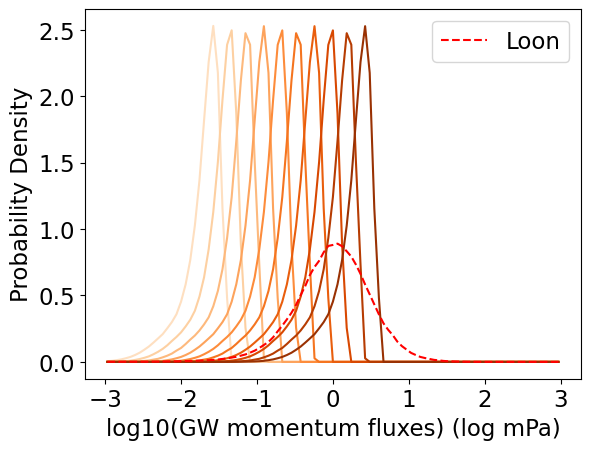

In [37]:

logbins_edge = np.linspace(-3,3,100)
logbins_centers = (logbins_edge[:-1] + logbins_edge[1:]) / 2
for i,s in enumerate(samples_Fs0):
    hist, _ = np.histogram(np.log10(s),bins=logbins_edge,density=True)
    plt.plot(logbins_centers, hist, c=plt.cm.Oranges((i+2) / (len(samples_Fs0) + 2)))
log_loon_hist, _ = np.histogram(np.log10(LOON_DATA['u_flux_ptv']),bins=logbins_edge,density=True)
plt.plot(logbins_centers, log_loon_hist, label='Loon', color='red',ls='--')
plt.xlabel('log10(GW momentum fluxes) (log mPa)')
plt.ylabel('Probability Density')
plt.legend()

Text(0, 0.5, 'Density')

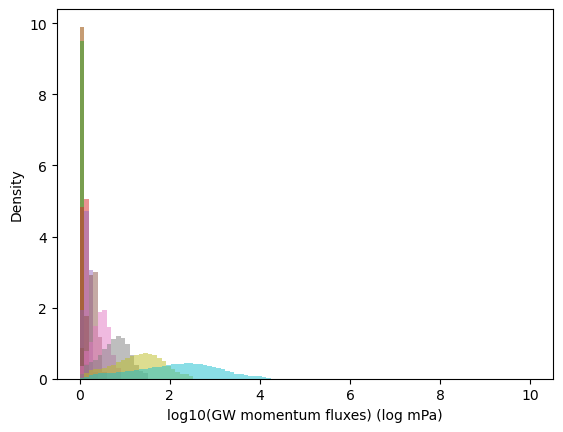

In [10]:
for s in samples_Fs0:
    plt.hist(s,bins=np.linspace(0,10,100),density=True,alpha=0.5)
plt.xlabel('log10(GW momentum fluxes) (log mPa)')
plt.ylabel('Density')


In [11]:
mean_true_Fs0, std_true_Fs0, skew_true_Fs0, kurt_true_Fs0 = moments_over_fluxes(samples_Fs0)
mean_log_Fs0, std_log_Fs0, skew_log_Fs0, kurt_log_Fs0 = moments_over_log_fluxes(samples_Fs0)

Text(0.5, 0.98, 'AD99 Fs0 shift')

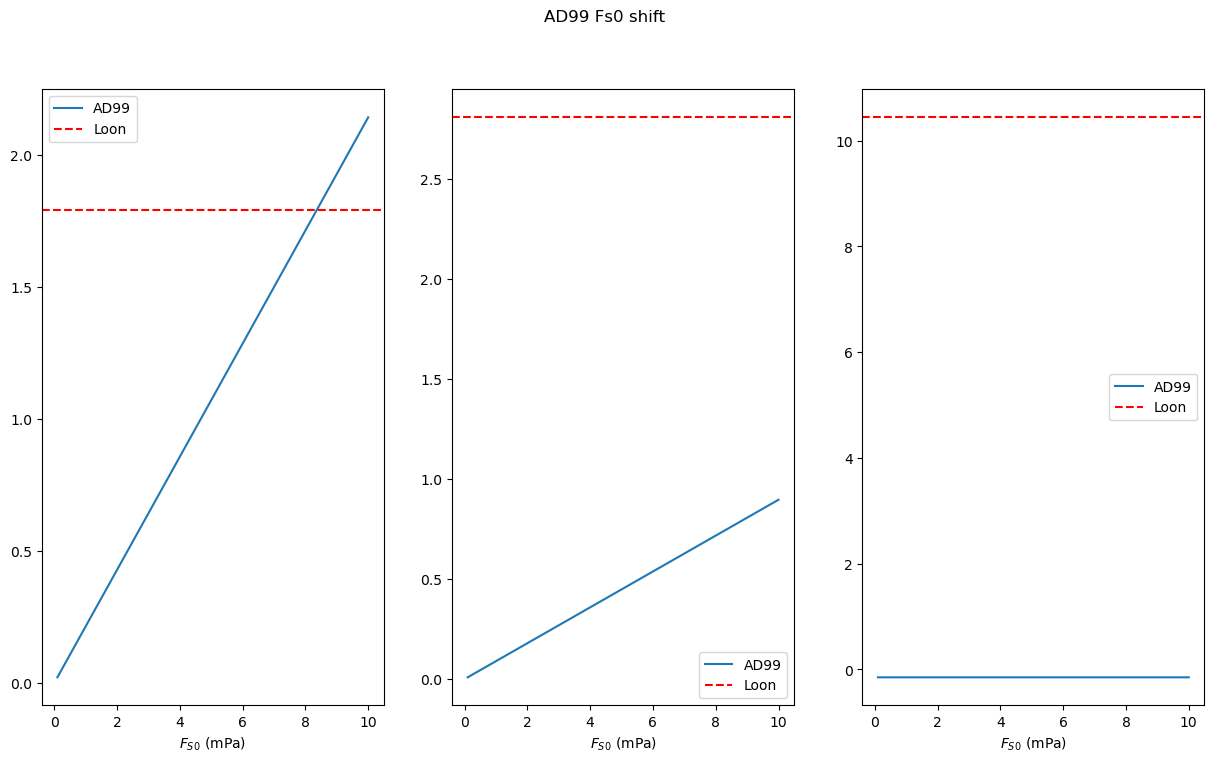

In [12]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,8))

ax1.plot(Fs0_range*1000,mean_true_Fs0,label='AD99')
ax1.set_xlabel('$F_{S0}$ (mPa)')
ax1.axhline(loon_mean,color='red',linestyle='--',label='Loon')
ax2.plot(Fs0_range*1000,std_true_Fs0,label='AD99')
ax2.set_xlabel('$F_{S0}$ (mPa)')
ax2.axhline(loon_std,color='red',linestyle='--',label='Loon')
ax3.plot(Fs0_range*1000,skew_true_Fs0,label='AD99')
ax3.set_xlabel('$F_{S0}$ (mPa)')
ax3.axhline(loon_skew,color='red',linestyle='--',label='Loon')

# ax1.legend()
ax1.legend()
ax2.legend()
ax3.legend()
fig.suptitle("AD99 Fs0 shift")

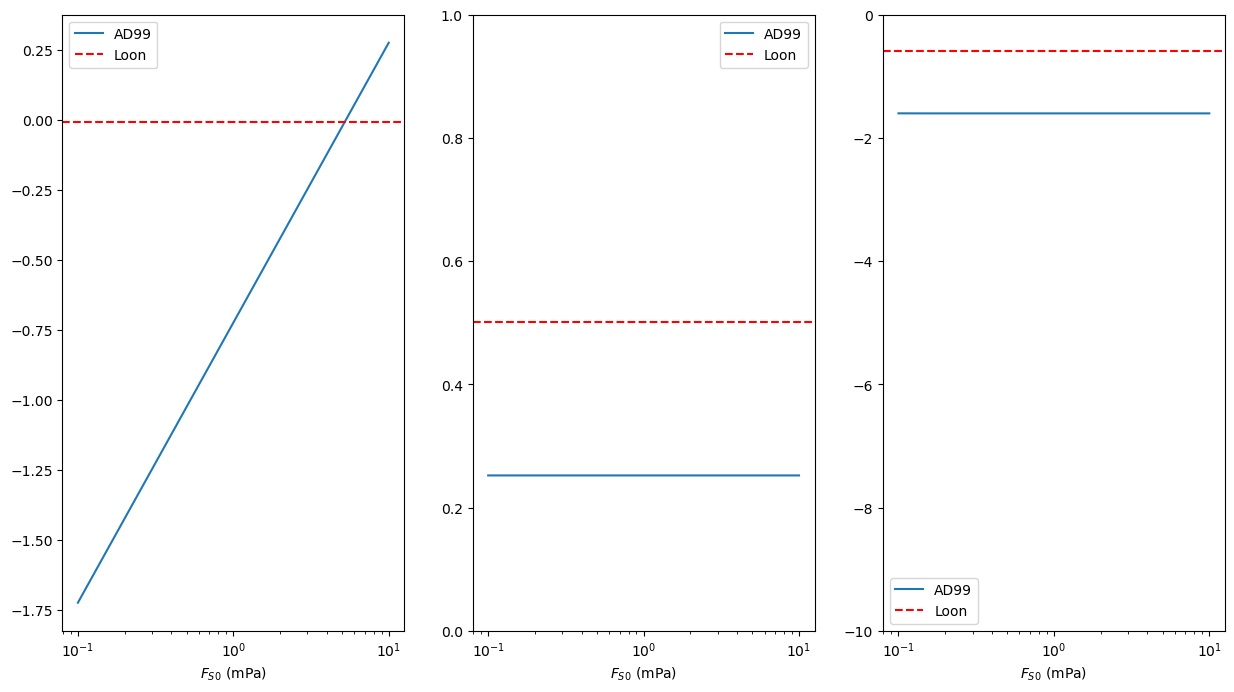

In [13]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,8))
predicted_skew= -3*np.array(std_true_Fs0)/np.array(mean_true_Fs0)
ax1.plot(Fs0_range*1000,mean_log_Fs0,label='AD99')
ax1.axhline(loon_log_mean,color='red',linestyle='--',label='Loon')
ax1.set_xlabel('$F_{S0}$ (mPa)')
ax1.set_xscale('log')
ax2.plot(Fs0_range*1000,std_log_Fs0,label='AD99')
ax2.axhline(loon_log_std,color='red',linestyle='--',label='Loon')
ax2.set_xlabel('$F_{S0}$ (mPa)')
ax2.set_ylim(0,1)
ax2.set_xscale('log')
ax3.plot(Fs0_range*1000,skew_log_Fs0,label='AD99')
ax3.axhline(loon_log_skew,color='red',linestyle='--',label='Loon')
ax3.set_xlabel('$F_{S0}$ (mPa)')
ax3.set_ylim(-10,0)
ax3.set_xscale('log')
ax1.legend()
ax2.legend() 
ax3.legend()
# ax1.legend()

In [14]:
predicted_skew

array([-1.25529243, -1.25529707, -1.25529707, -1.25529707, -1.25529707,
       -1.25529707, -1.25529707, -1.25529707, -1.25529707, -1.25529707])

## Phase speed distribution width ($c_w$)

In [15]:
from ad99py.sources import gaussian_source,make_source_spectrum
cw = np.arange(5,80,5) 
samples_cw = []
for i,cwi in tqdm(enumerate(cw),total=len(cw),desc='$c_w$'):
    source = make_source_spectrum(gaussian_source,cw=cwi,Bm=0.4)
    ad99 = AlexanderDunkerton1999Dask(Fs0=4.3e-3,source=source)
    _,ptv_flux = ad99.momentum_flux_neg_ptv(ds_gcm.u.data,ds_gcm.Ns.data,ds_gcm.z.data,ds_gcm.rho.data,lat)
    samples_cw.append(filter_scale(ptv_flux[...,i_lvl]).compute())



$c_w$:   0%|          | 0/15 [00:00<?, ?it/s]

In [16]:
mean_true_cw, std_true_cw, skew_true_cw, kurt_true_cw = moments_over_fluxes(samples_cw)
mean_log_cw, std_log_cw, skew_log_cw, kurt_log_cw = moments_over_log_fluxes(samples_cw)

(0.0, 5.0)

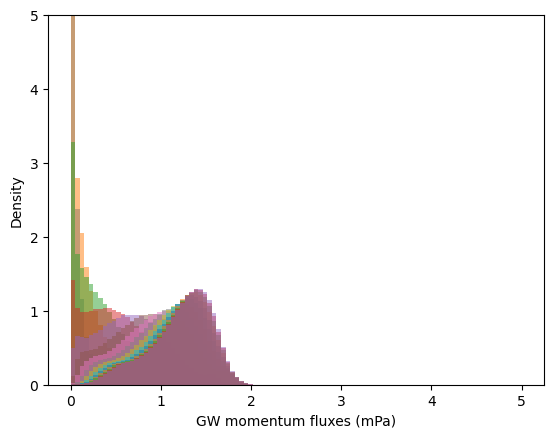

In [17]:
for s in samples_cw:
    plt.hist(s,bins=np.linspace(0,5,100),density=True,alpha=0.5)
plt.xlabel('GW momentum fluxes (mPa)')
plt.ylabel('Density')
plt.ylim(0,5)


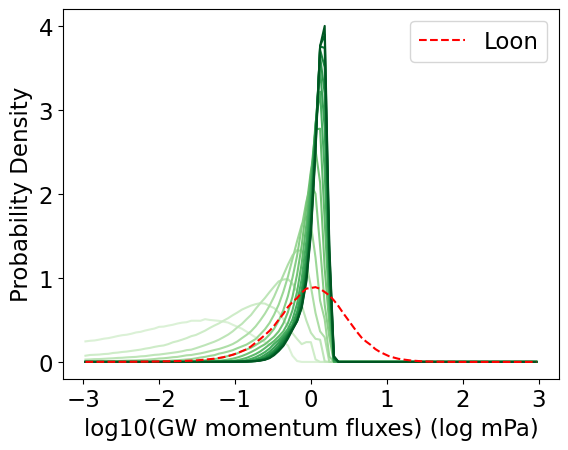

In [38]:

logbins_edge = np.linspace(-3,3,100)
logbins_centers = (logbins_edge[:-1] + logbins_edge[1:]) / 2
for i,s in enumerate(samples_cw):
    hist, _ = np.histogram(np.log10(s),bins=logbins_edge,density=True)
    plt.plot(logbins_centers, hist, c=plt.cm.Greens((i+3) / (len(samples_cw) + 3)))
log_loon_hist, _ = np.histogram(np.log10(LOON_DATA['u_flux_ptv']),bins=logbins_edge,density=True)
plt.plot(logbins_centers, log_loon_hist, label='Loon', color='red',ls='--')
plt.xlabel('log10(GW momentum fluxes) (log mPa)')
plt.ylabel('Probability Density')
plt.legend()

Text(0.5, 0.98, 'AD99 $c_w$ shift')

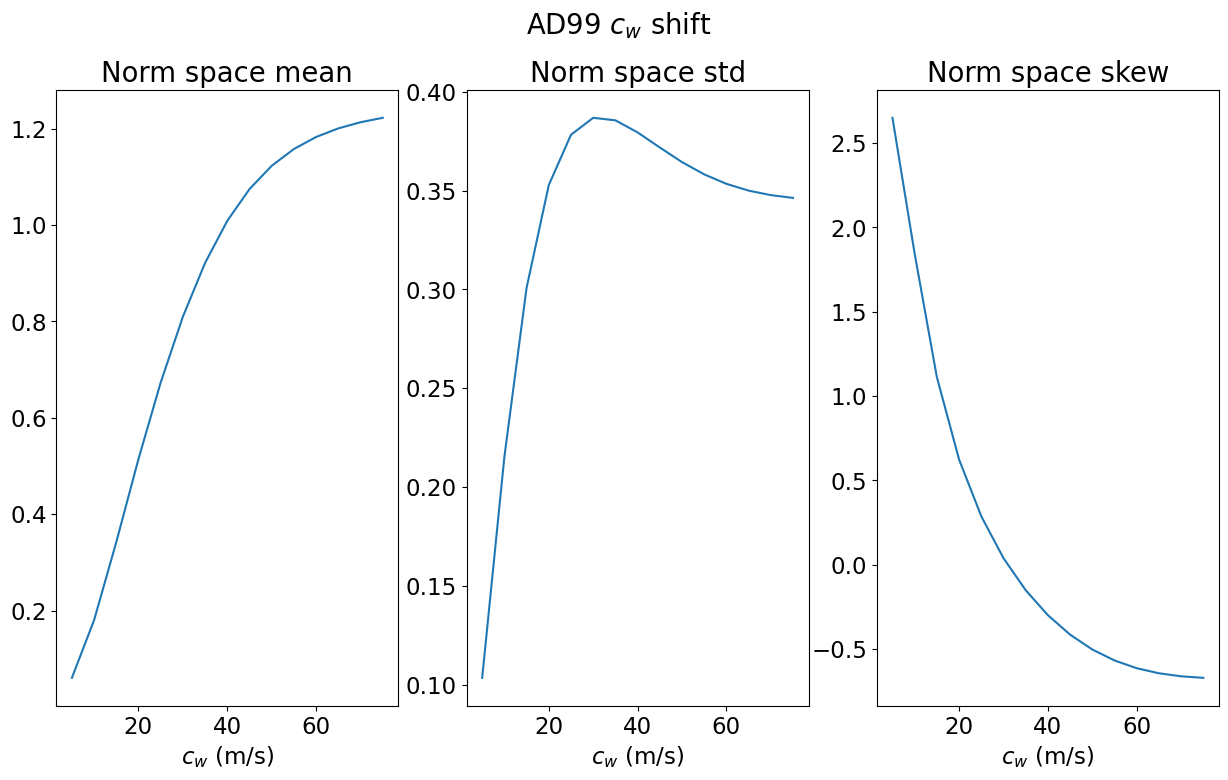

In [39]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,8))
ax1.set_title("Norm space mean")
ax1.plot(cw,mean_true_cw,label='GW momentum fluxes')
ax1.set_xlabel('$c_w$ (m/s)')
ax2.set_title("Norm space std")
ax2.plot(cw,std_true_cw,label='GW momentum fluxes')
ax2.set_xlabel('$c_w$ (m/s)')
ax3.set_title("Norm space skew")
ax3.plot(cw,skew_true_cw,label='GW momentum fluxes')
ax3.set_xlabel('$c_w$ (m/s)')

# ax1.legend()
fig.suptitle("AD99 $c_w$ shift")

Text(0.5, 0.98, 'AD99 $c_w$ shift')

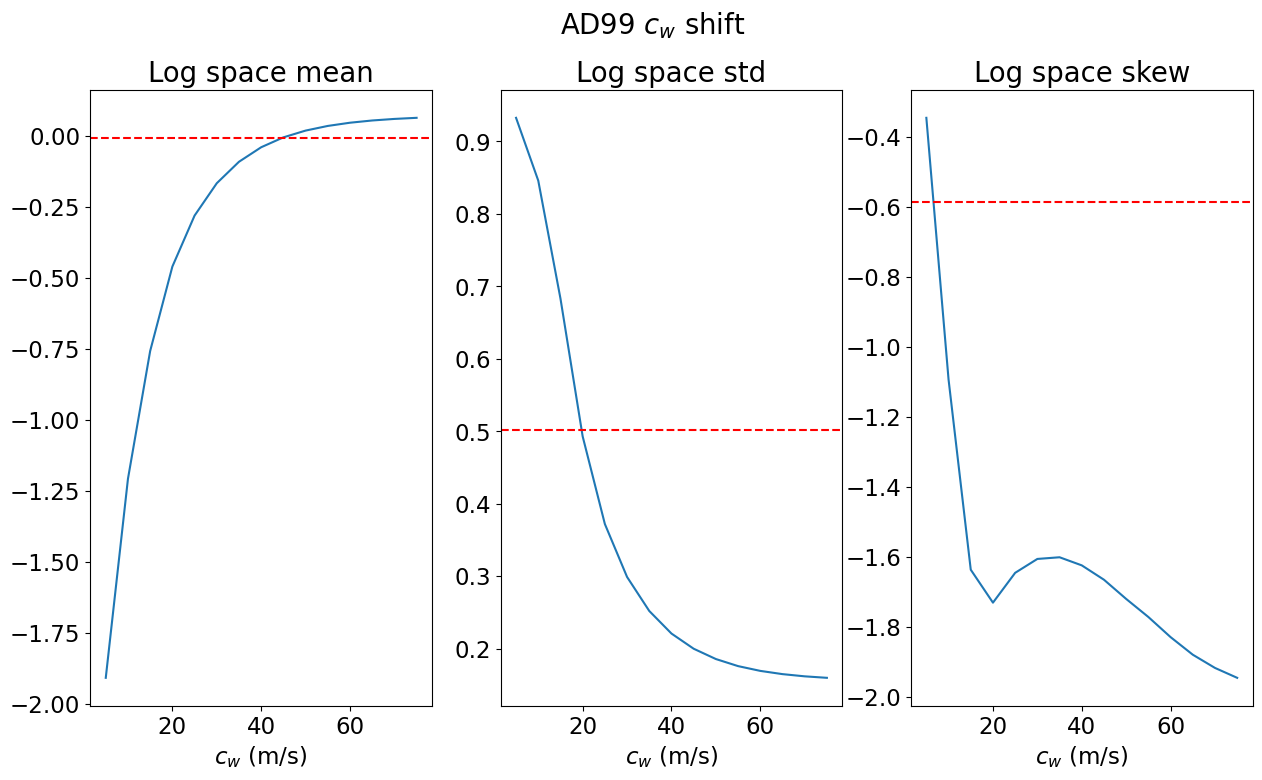

In [40]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,8))

ax1.plot(cw,mean_log_cw,label='AD99')
ax1.axhline(loon_log_mean,color='red',linestyle='--',label='Loon')
ax1.set_xlabel('$c_w$ (m/s)')
ax1.set_title("Log space mean")
ax2.plot(cw,std_log_cw,label='AD99')
ax2.axhline(loon_log_std,color='red',linestyle='--',label='Loon')
ax2.set_xlabel('$c_w$ (m/s)')
ax2.set_title("Log space std")
ax3.plot(cw,skew_log_cw,label='AD99')
ax3.axhline(loon_log_skew,color='red',linestyle='--',label='Loon')
ax3.set_xlabel('$c_w$ (m/s)')
ax3.set_title("Log space skew")

# ax1.legend()
fig.suptitle("AD99 $c_w$ shift")

Text(0.5, 1.0, 'Log space skew')

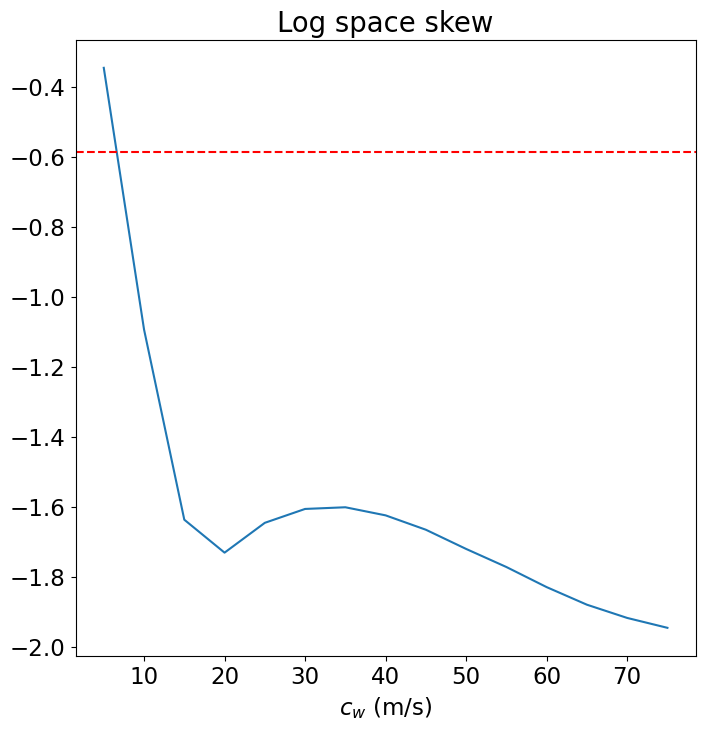

In [41]:
fig,ax3 = plt.subplots(figsize=(8,8))

ax3.plot(cw,skew_log_cw,label='AD99')
ax3.axhline(loon_log_skew,color='red',linestyle='--',label='Loon')
ax3.set_xlabel('$c_w$ (m/s)')

ax3.set_title("Log space skew")

### ($B_m$)

In [21]:
Bm = np.logspace(-1,2,15)
samples_Bm = []

for i,Bmi in tqdm(enumerate(Bm),total=len(Bm),desc='$B_m$'):
    source = make_source_spectrum(gaussian_source,cw=35,Bm=Bmi)
    ad99 = AlexanderDunkerton1999Dask(Fs0=4.3e-3,source=source)
    _,ptv_flux = ad99.momentum_flux_neg_ptv(ds_gcm.u.data,ds_gcm.Ns.data,ds_gcm.z.data,ds_gcm.rho.data,lat)
    samples_Bm.append(filter_scale(ptv_flux[...,i_lvl]).compute())

$B_m$:   0%|          | 0/15 [00:00<?, ?it/s]

In [22]:
mean_true_Bm, std_true_Bm, skew_true_Bm, kurt_true_Bm = moments_over_fluxes(samples_Bm)
mean_log_Bm, std_log_Bm, skew_log_Bm, kurt_log_Bm = moments_over_log_fluxes(samples_Bm)

(0.0, 2.0)

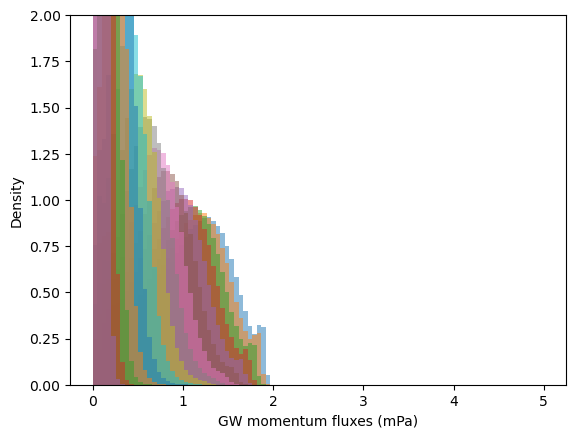

In [23]:
for s in samples_Bm:
    plt.hist(s,bins=np.linspace(0,5,100),density=True,alpha=0.5)
plt.xlabel('GW momentum fluxes (mPa)')
plt.ylabel('Density')
plt.ylim(0,2)


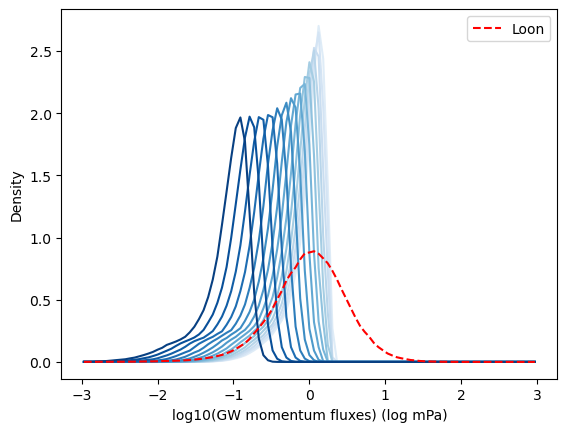

In [24]:

logbins_edge = np.linspace(-3,3,100)
logbins_centers = (logbins_edge[:-1] + logbins_edge[1:]) / 2
for i,s in enumerate(samples_Bm):
    hist, _ = np.histogram(np.log10(s),bins=logbins_edge,density=True)
    plt.plot(logbins_centers, hist, c=plt.cm.Blues((i+2) / (len(samples_Bm) + 2)))
log_loon_hist, _ = np.histogram(np.log10(LOON_DATA['u_flux_ptv']),bins=logbins_edge,density=True)
plt.plot(logbins_centers, log_loon_hist, label='Loon', color='red',ls='--')
plt.xlabel('log10(GW momentum fluxes) (log mPa)')
plt.ylabel('Density')
plt.legend()

Text(0.5, 0.98, 'AD99 $B_m$ shift')

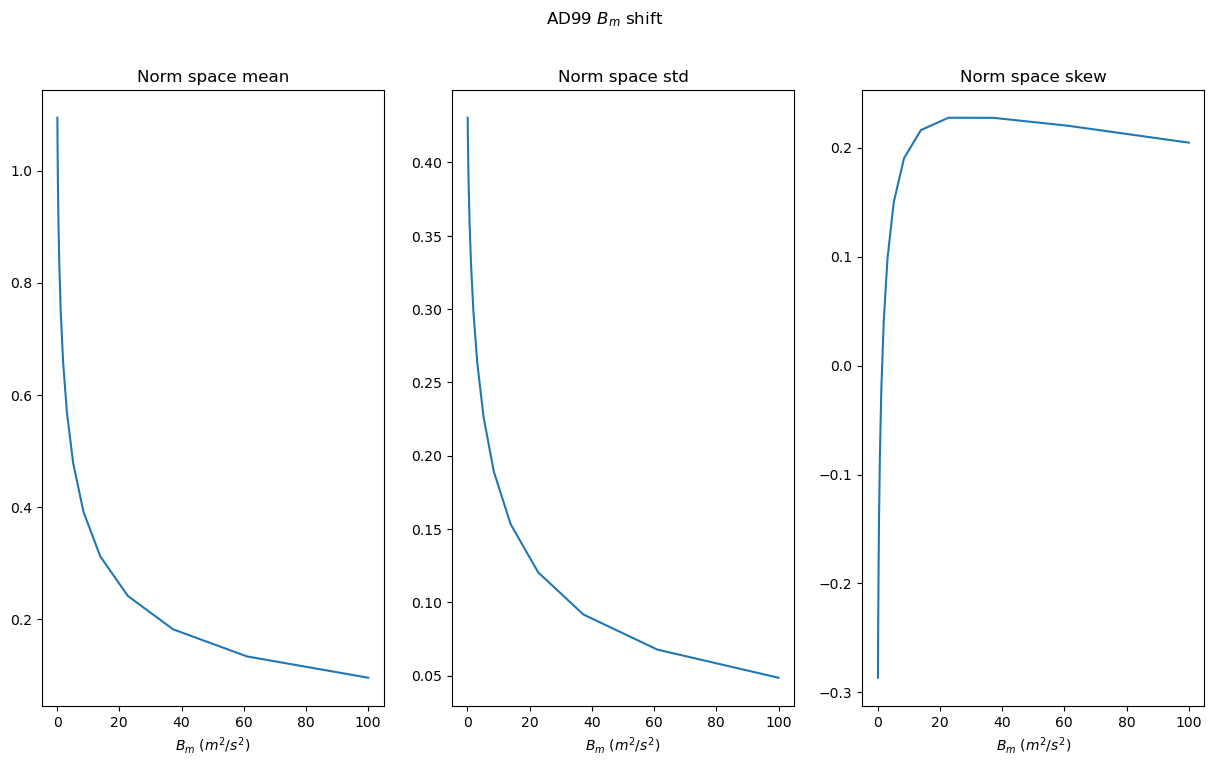

In [25]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,8))
ax1.set_title("Norm space mean")
ax1.plot(Bm,mean_true_Bm,label='GW momentum fluxes')
ax1.set_xlabel('$B_m$ ($m^2/s^2$)')
ax2.set_title("Norm space std")
ax2.plot(Bm,std_true_Bm,label='GW momentum fluxes')
ax2.set_xlabel('$B_m$ ($m^2/s^2$)')
ax3.set_title("Norm space skew")
ax3.plot(Bm,skew_true_Bm,label='GW momentum fluxes')
ax3.set_xlabel('$B_m$ ($m^2/s^2$)')

# ax1.legend()
fig.suptitle("AD99 $B_m$ shift")

Text(0.5, 0.98, 'AD99 $B_m$')

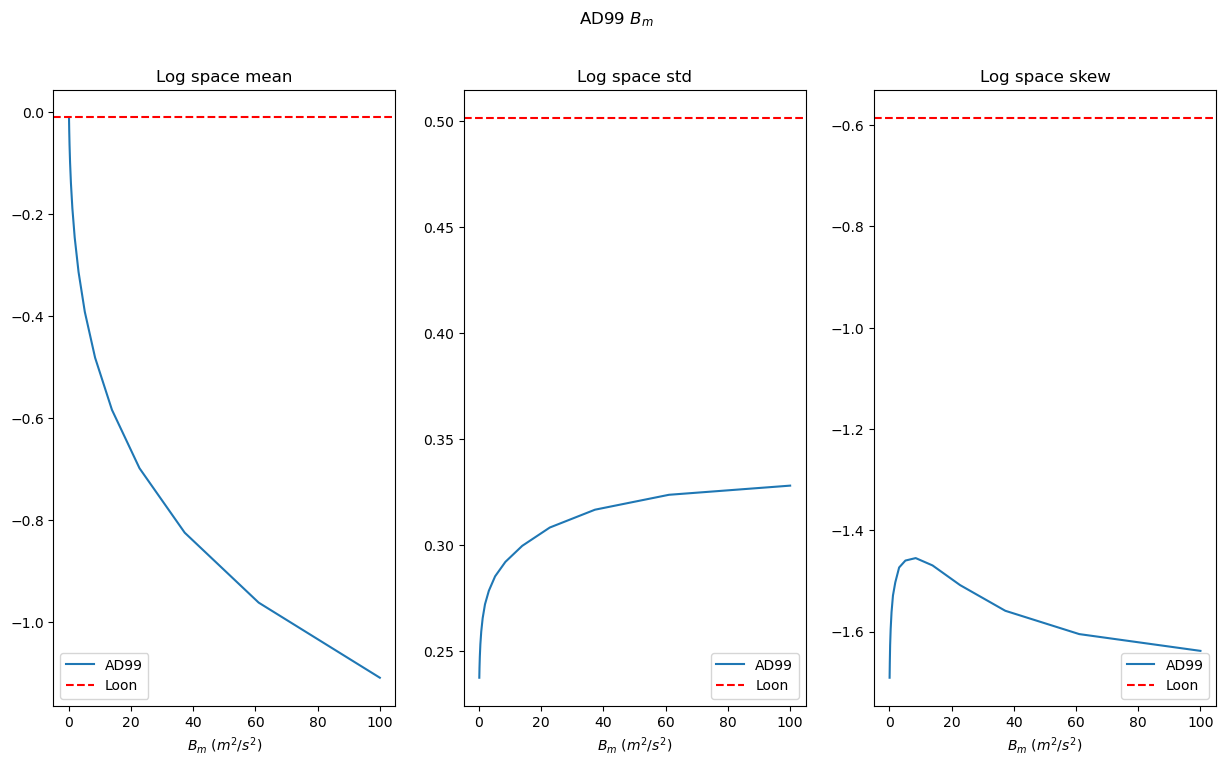

In [26]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,8))

ax1.plot(Bm,mean_log_Bm,label='AD99')
ax1.axhline(loon_log_mean,color='red',linestyle='--',label='Loon')
ax1.set_xlabel('$B_m$ ($m^2/s^2$)')
ax1.set_title("Log space mean")
ax2.plot(Bm,std_log_Bm,label='AD99')
ax2.axhline(loon_log_std,color='red',linestyle='--',label='Loon')
ax2.set_xlabel('$B_m$ ($m^2/s^2$)')
ax2.set_title("Log space std")
ax3.plot(Bm,skew_log_Bm,label='AD99')
ax3.axhline(loon_log_skew,color='red',linestyle='--',label='Loon')
ax3.set_xlabel('$B_m$ ($m^2/s^2$)')
ax3.set_title("Log space skew")
ax1.legend()
ax2.legend()
ax3.legend()
# ax1.legend()
fig.suptitle("AD99 $B_m$")

In [27]:
ad99_opt = AlexanderDunkerton1999Dask(Fs0=43,Bm=35000,cw=35,dc=0.4)

_,ptv_flux = ad99_opt.momentum_flux_neg_ptv(ds_gcm.u.data,ds_gcm.Ns.data,ds_gcm.z.data,ds_gcm.rho.data,lat)

/Users/robcking/PhD/ad99py/src/ad99py/ad99.py:65: UserWarning: `source` is not set, using default Gaussian source spectrum, with `cw=35` and `Bm=35000`.
  warn(f"`source` is not set, using default Gaussian source spectrum, with `cw={cw}` and `Bm={Bm}`.")


In [89]:
flt_opt_flux = filter_scale(ptv_flux[...,i_lvl]).compute()

In [111]:
def gaussian_pdf(x,mu,sigma):
    return (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-0.5*((x-mu)/sigma)**2)

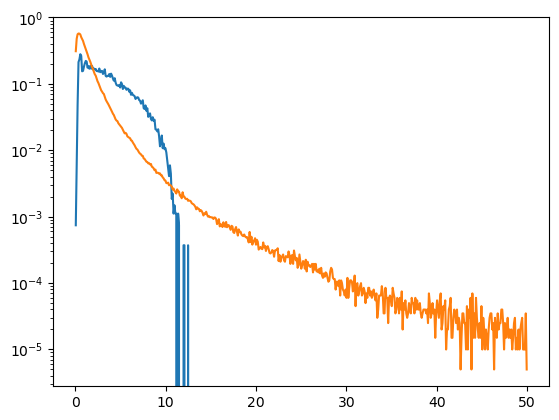

In [120]:
bins_edge = np.linspace(0,50,500)
bins_centers = 0.5*(bins_edge[1:] + bins_edge[:-1])
hist, _ = np.histogram(flt_opt_flux,bins=bins_edge,density=True)
hist_loon, _ = np.histogram(LOON_DATA['u_flux_ptv'],bins=bins_edge,density=True)
plt.plot(bins_centers,hist)
plt.plot(bins_centers,hist_loon)
plt.yscale('log')

Text(0, 0.5, 'Density')

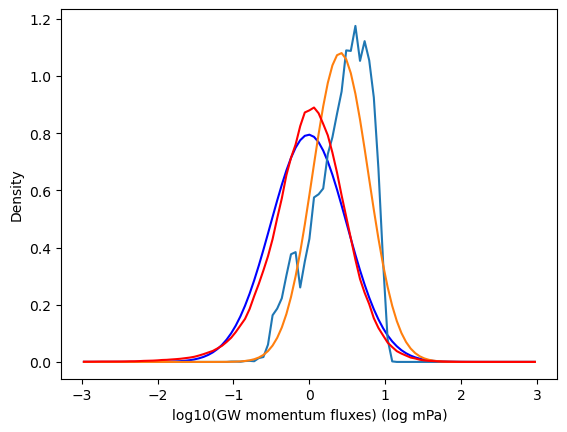

In [119]:
logbins_edge = np.linspace(-3,3,100)
logbins_centers = (logbins_edge[:-1] + logbins_edge[1:]) / 2
hist, _ = np.histogram(np.log10(flt_opt_flux),bins=logbins_edge,density=True)
hist_loon, _ = np.histogram(np.log10(LOON_DATA['u_flux_ptv']),bins=logbins_edge,density=True)
plt.plot(logbins_centers, gaussian_pdf(logbins_centers, np.log10(LOON_DATA['u_flux_ptv']).mean(), np.log10(LOON_DATA['u_flux_ptv']).std()), label='AD99', color='blue')
plt.plot(logbins_centers, hist)
plt.plot(logbins_centers,gaussian_pdf(logbins_centers,np.log10(flt_opt_flux).mean(),np.log10(flt_opt_flux).std()))
plt.plot(logbins_centers, hist_loon, label='Loon', color='red')
plt.xlabel('log10(GW momentum fluxes) (log mPa)')
plt.ylabel('Density')   

In [130]:
moments_over_log_fluxes([flt_opt_flux])

([np.float32(0.40927362)],
 [np.float32(0.3688852)],
 [np.float64(-0.627110481262207)],
 [np.float32(2.6505206)])

In [131]:
moments_over_log_fluxes([LOON_DATA['u_flux_ptv']])

([np.float64(-0.009352179068293809)],
 [np.float64(0.5016991838871291)],
 [np.float64(-0.585350227833401)],
 [np.float64(5.278139228494459)])

In [ ]:
plt.hist